### Analyze the possible relationships between Hot Water Energy and other variables

In [1]:
# including the project directory to the notebook level
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#importing modules
from scipy.fftpack import fft
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt

#modules for data reading and parsing dates
from dataprocess import dataprocessor as dp

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


Collecting only the hot water energy relevant features

In [5]:
df = df[['oat', 'sat', 'orh', 'hwe', 'ghi', 'avg_stpt', 'hw_sf', 'hw_st', 'hw_rt']]

Finished 'dataframeplot' in 0.2360 secs


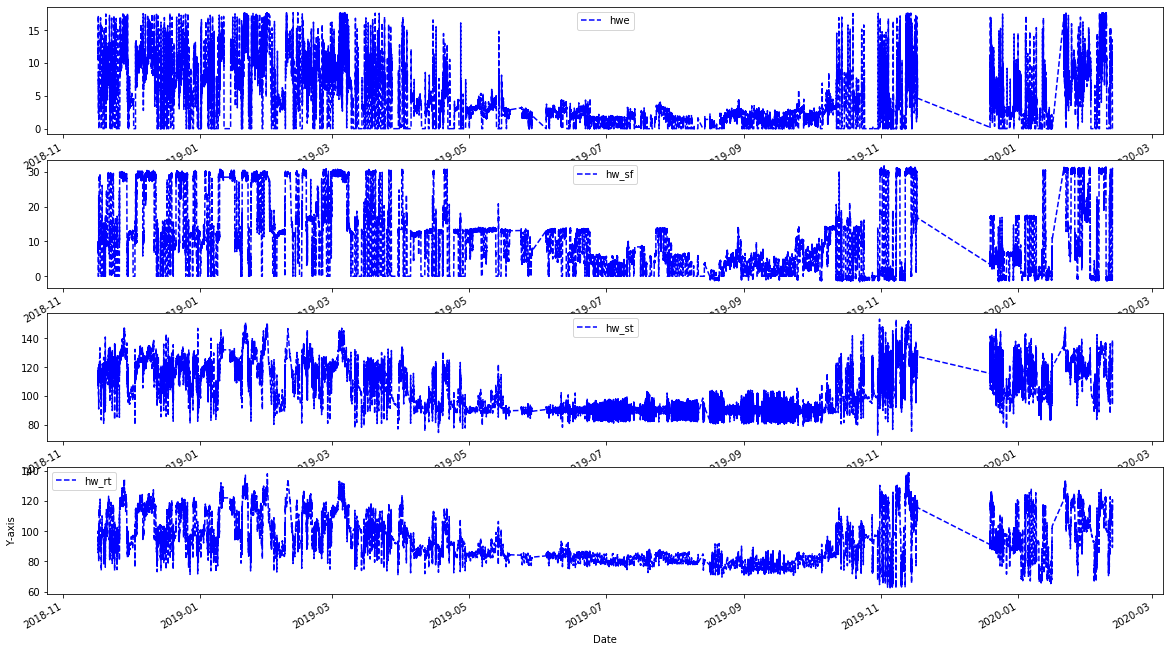

In [7]:
dp.dataframeplot(df = df[['hwe', 'hw_sf', 'hw_st', 'hw_rt']],
                xlabel='Date',
                lazy=False, 
                legend=True)#, squeeze=False

In [ ]:
# looking at the frequency content of the columns
T = 300  # sampling_period in seconds
dp.frequencyplot(df,T=T)

In [10]:
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

df_smoothed = dp.dfsmoothing(df=df,
                             column_names=list(df.columns),
                             order=order,
                             Wn=cutoff,
                             T=T)

In [17]:
df_smoothed.head()

,oat,sat,orh,hwe,ghi,avg_stpt,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.174578,73.440944,84.869274,12.076660,522.899415,72.432976,7.235171,107.038010,98.443674
2018-11-16 10:10:00,31.157023,73.209183,85.117973,11.874578,531.501114,72.430990,7.591253,107.744606,97.978636
2018-11-16 10:15:00,31.133383,72.975993,85.367264,11.676810,540.210064,72.429106,7.930512,108.446319,97.504855
2018-11-16 10:20:00,31.104418,72.744022,85.617456,11.488567,548.932472,72.427397,8.245544,109.128493,97.023846
2018-11-16 10:25:00,31.071189,72.516016,85.868914,11.315112,557.565771,72.425937,8.528969,109.776841,96.537417


In [18]:
!pip install ruptures

  Created wheel for ruptures: filename=ruptures-1.0.3-py3-none-any.whl size=55251 sha256=ea553d299c6898e8ddff0f98b9e0a21fd7b45442a719e7f8779f9460cad006b0
  Stored in directory: /home/nauga/.cache/pip/wheels/49/8c/77/2af1d8f92bcd0e0a7de0585b203ec6baccc24a529440b87b8c
Successfully built ruptures


In [19]:
import matplotlib.pyplot as plt
import ruptures as rpt

In [37]:
signal = df[['hwe']].to_numpy().flatten()[:288]

In [38]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=12, model=model).fit(signal)

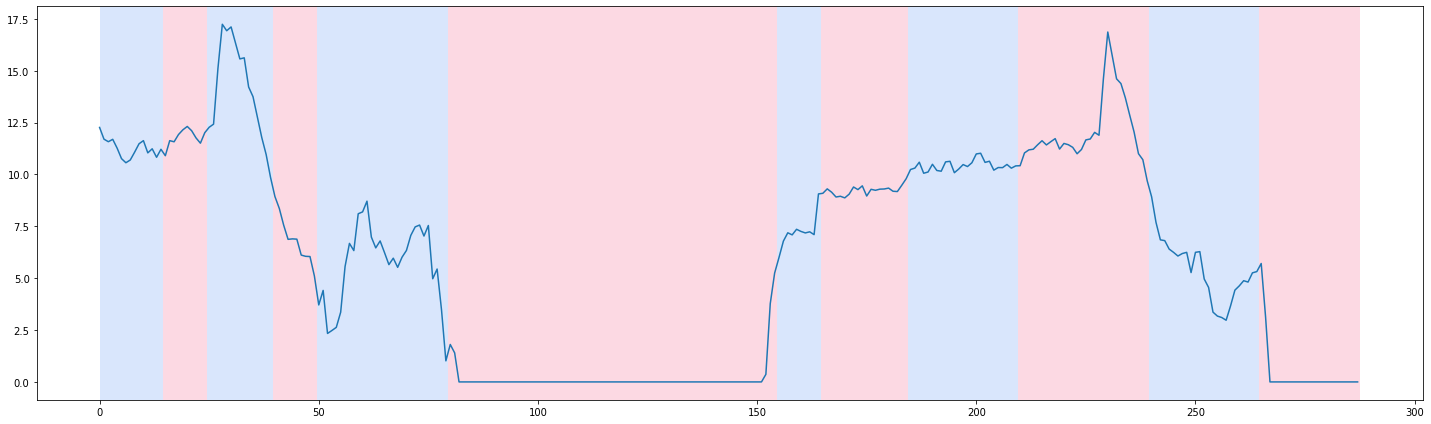

In [39]:
# show results
my_bkps = algo.predict(n_bkps=100)
rpt.show.display(signal, my_bkps, figsize=(20, 6))
plt.show()

### Testing butterworth smoothing on some data

<IPython.core.display.Javascript object>


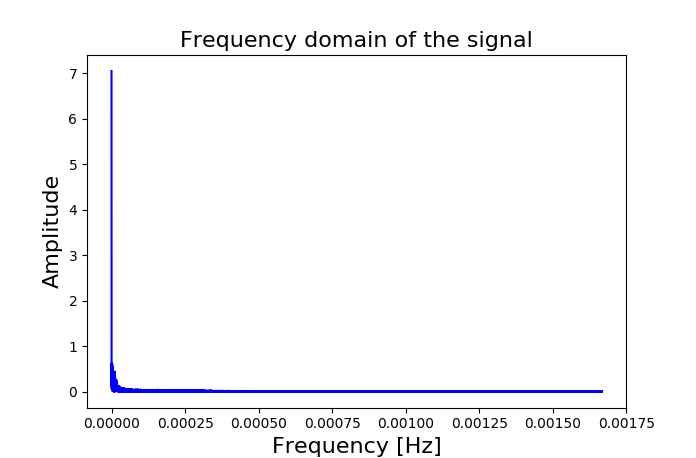

In [14]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

T = 300  # sampling period
f_s = 1/T
N = df['hwe'].shape[0]
composite_y_value = df['hwe'].to_numpy()
f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

plt.figure(figsize=(7,4))
plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

In [15]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

<IPython.core.display.Javascript object>


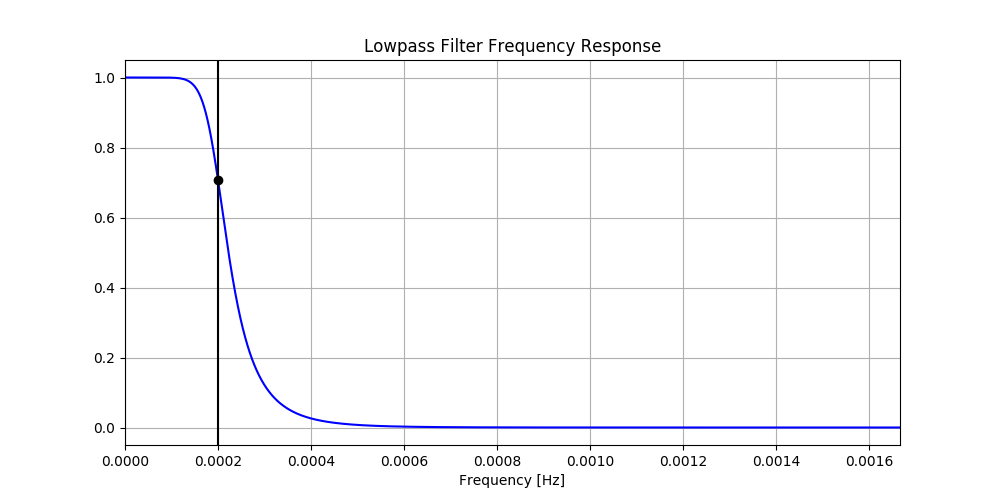

In [16]:
# Filter requirements.
order = 5
T = 300  # sampling_period in seconds
fs = 1/300       # sample rate, Hz
cutoff = 0.0002  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure(figsize=(10,5))
# plt.xscale('log')
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

<IPython.core.display.Javascript object>


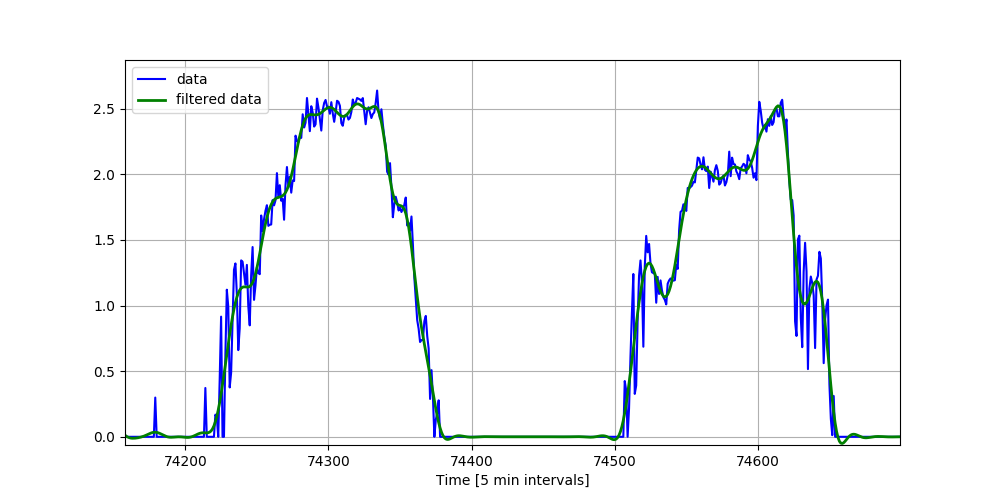

In [17]:
# Filter the data, and plot both the original and filtered signals.
data = df['hwe'].to_numpy()
y = butter_lowpass_filter(data, cutoff, fs, order)
plt.figure(figsize=(10,5))
plt.plot(data, 'b-', label='data')
plt.plot(y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [5 min intervals]')
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)
plt.show()